# Training our CNN baseline model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os,sys
from torch.utils.data import random_split, DataLoader
import torch
import torchvision.transforms.functional as TF

## Set up the environment 

In [ ]:
root_dir = "/content/drive/Shareddrives/road-segmentation/data/" if "google.colab" in sys.modules else "data/"
img_path = root_dir + "training/images/"
gt_path = root_dir + "training/groundtruth/"
test_path = root_dir + "test_set_images/"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True, use_metadata_server=False)

Mounted at /content/drive


In [5]:
from src import training   
from src.models.patch_model import PatchModel
from src.patched_image_dataset import PatchedSatImagesDataset, PatchedTestSatImagesDataset

## Load the data

In [7]:
batch_size = 100
threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

dataset = PatchedSatImagesDataset(img_path, gt_path, threshold)

# Perform data augmentation by rotation and shearing
angles = [15, -10, 45, -60, 78]
for angle in angles:
    rotation = lambda img: TF.rotate(img, angle)
    dataset += PatchedSatImagesDataset(img_path, gt_path, threshold, rotation)
    
shears = [[15, 20], [10, 30], [30, -17], [-3, 20], [-5, -10]]
for shear in shears:
    transformation = lambda img: TF.affine(img, angle=0, scale=1.0, translate=[0, 0], shear=shear)
    dataset += PatchedSatImagesDataset(img_path, gt_path, threshold, transformation)

# Split the data in 80/20 for training and validation
data_len = len(dataset)
train_len = int(data_len * 0.8)
test_len = int(data_len * 0.2)

dataset_train, dataset_test = random_split(dataset, [train_len, test_len])

print(len(dataset_train), len(dataset_test))

# Load the data using a dataloader
dataloader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=True
)

550000 137500


## Learning Rate Finder

In [ ]:
!pip install torch-lr-finder


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.14E-02


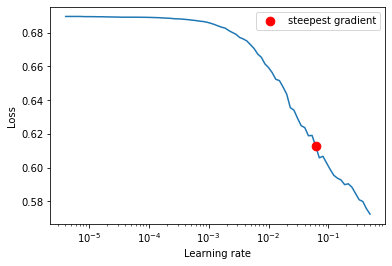

In [36]:
from torch_lr_finder import LRFinder

criterion = torch.nn.BCELoss()
model = PatchModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum = 0.9)

# Use the LR-finder to find the optimal learning rate
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader_train, end_lr=1, num_iter=100)
lr_finder.plot() # Plot resuling graph: loss as a function of epochs 
lr_finder.reset()

## Train the model

In [37]:
learning_rate = 8e-2
decay_rate = 0.95

# Initialize training with the right optimizer and criterion
model = PatchModel().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)

Adjusting learning rate of group 0 to 8.0000e-02.


In [ ]:
# Train the model for a 100 epochs, and save it every 20
for i in range(0, 101, 20):
    training.train(model, criterion, dataloader_train, dataloader_test, optimizer, scheduler, 20)
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, '/content/drive/Shareddrives/road-segmentation/cnn_{}_sgdmomentum_lr{}_decay{}'.format(i, learning_rate, decay_rate))

## Predict output for testing images

In [44]:
# Reload the desired model
checkpoint = torch.load('/content/drive/Shareddrives/road-segmentation/cnn_100_sgdmomentum_lr0.08_decay0.95')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [45]:
# Load the training data
submission = PatchedTestSatImagesDataset(test_path)
dataloader_submission = DataLoader(
    submission, 
    batch_size=1,
    shuffle=False
)

# Predict the outputs for each patch and write to submission file
with open('submission.csv', 'w') as f:
    f.write('id,prediction\n')
    model.eval()
    for img_id, X in dataloader_submission:
        X = X.to(device)
        Y = model(X).item()
        f.write(f'{img_id[0]},{Y}\n')        